In [1]:
# try:
#     import varseek as vk
# except ImportError:
#     print("varseek not found, installing...")
#     !pip install -U -q varseek
# try:
#     import RLSRWP_2025
# except ImportError:
#     print("RLSRWP_2025 not found, installing...")
#     !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git

In [2]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import seaborn as sns
import re
import anndata as ad

import varseek as vk
from RLSRWP_2025.constants import box_links_dict

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025
data_dir = os.path.join(RLSRWP_2025_dir, "data")

In [3]:
# #!!! dummy data to be erased

# # Define shared dimensions
# n_obs = 5
# n_vars = 50

# # Create shared obs and var
# obs = pd.DataFrame(index=[f"cell{i}" for i in range(n_obs)])
# variant_var = pd.DataFrame(index=[f"vcrs{j}" for j in range(n_vars)])
# variant_var["variant_header"] = variant_var.index
# gene_var = pd.DataFrame(index=[f"gene{j}" for j in range(n_vars)])

# # Generate random matrices
# X_vcrs = np.random.randint(0, 101, size=(n_obs, n_vars))
# X_reference = np.random.randint(0, 101, size=(n_obs, n_vars))
# X_genotype = np.random.choice([0, 1, 2], size=(n_obs, n_vars))

# # Create the AnnData objects
# adata_vcrs = ad.AnnData(X=X_vcrs, obs=obs.copy(), var=variant_var.copy())
# adata_reference = ad.AnnData(X=X_reference, obs=obs.copy(), var=gene_var.copy())
# adata_genotype = ad.AnnData(X=X_genotype, obs=obs.copy(), var=variant_var.copy())

In [4]:
sequencing_data_out_base = os.path.join(data_dir, "geuvadis_data_base")
geuvadis_reference_files_dir = os.path.join(data_dir, "reference", "geuvadis")
geuvadis_genotype_true_adata = os.path.join(geuvadis_reference_files_dir, "genotypes_adata_true.h5ad")
reference_genome_t2g = os.path.join(data_dir, "reference", "ensembl_grch37_release113", "t2g.txt")

adata_combined_path_reference_genome = os.path.join(sequencing_data_out_base, "adata_reference_genome_combined.h5ad")

w_and_k_list_of_dicts = [
    {"w": 27, "k": 31},
    {"w": 37, "k": 41},
    {"w": 47, "k": 51},
]

sample_index = 0  # sample to focus on - lowest is 0 (index in adata)
min_counts = 2

out_dir = os.path.join(data_dir, "geuvadis_analysis")

In [5]:
if not os.path.isfile(adata_combined_path_reference_genome):
    vk.utils.download_box_url(box_links_dict["geuvadis_adata_reference_genome"], output_file_name=adata_combined_path_reference_genome)
if not os.path.isfile(geuvadis_genotype_true_adata):
    vk.utils.download_box_url(box_links_dict["geuvadis_adata_genotype"], output_file_name=geuvadis_genotype_true_adata)

adata_reference = ad.read_h5ad(adata_combined_path_reference_genome)
adata_genotype = ad.read_h5ad(geuvadis_genotype_true_adata)

os.makedirs(out_dir, exist_ok=True)

In [6]:
#!!! ensure that this file is downloadable etc
variants_transcriptome_df = pd.read_parquet("/home/jmrich/Desktop/RLSRWP_2025/data/reference/geuvadis/variants_transcriptome.parquet")
variants_transcriptome_df['variant_header_cdna'] = variants_transcriptome_df['transcript_ID'] + ":" + variants_transcriptome_df['variant_cdna']
adata_genotype.var = adata_genotype.var.merge(variants_transcriptome_df[["variant_header", "variant_header_cdna"]], how="left", on="variant_header")
adata_genotype.var.rename(columns={"variant_header": "variant_header_cds", "variant_header_cdna": "variant_header"}, inplace=True)
adata_genotype.var.index = adata_genotype.var.index.astype(str)  # otherwise I get AssertionError: Don’t call _normalize_index with non-categorical/string names
adata_genotype.obs.index = adata_genotype.obs.index.astype(str)
adata_genotype.obs['sample_title'] = adata_genotype.obs.index.astype(str).str.slice(2)

adata_reference.var['gene'] = adata_reference.var.index.str.split(".").str[0]

In [7]:
adata_genotype.var.head()

,has_id,ID,variant_header_cds,variant_header
0,True,rs200036735,ENST00000327044.6:c.106C>T,ENST00000327044:c.156C>T
1,True,rs201791495,ENST00000327044.6:c.57C>T,ENST00000327044:c.107C>T
2,True,rs192245893,ENST00000338591.3:c.90A>C,ENST00000338591:c.197A>C
3,True,rs200516692,ENST00000338591.3:c.163G>A,ENST00000338591:c.270G>A
4,True,rs199679371,ENST00000338591.3:c.189G>A,ENST00000338591:c.296G>A


In [8]:
# vcf = pd.read_parquet("/home/jmrich/Desktop/RLSRWP_2025/data/reference/geuvadis/1kg_phase1_all_preliminary_vcf_exons.parquet")
# vcf.head()

## Plot Venn diagrams for my k-series to determine the best variant matrix to use

In [9]:
# import pysam
# import pandas as pd

# vcf_path_preliminary = "/home/jmrich/Desktop/RLSRWP_2025/data/reference/geuvadis/1kg_phase1_all_preliminary_exons.vcf.gz"
# vcf_path_true = "/home/jmrich/Desktop/RLSRWP_2025/data/reference/geuvadis/1kg_phase1_all_true.vcf.gz"
# sample = "0_HG00377"

# vcf_preliminary = pysam.VariantFile(vcf_path_preliminary)
# vcf_true = pysam.VariantFile(vcf_path_true)

# # Check sample names
# if sample not in vcf_preliminary.header.samples:
#     raise ValueError("Sample sample not found in VCF")

# variants_possessed_by_this_sample = set()
# for rec_preliminary, rec_true in zip(vcf_preliminary, vcf_true):
#     if rec_preliminary.ref == rec_true.ref:
#         sample_homozygous_ref = rec_preliminary.samples[sample].get("GT") == (0, 0)
#     else:
#         sample_homozygous_ref = rec_preliminary.samples[sample].get("GT") == (1, 1)
#     if not sample_homozygous_ref:
#         variants_possessed_by_this_sample.add(rec_preliminary.id)


k=31
Sample HG00377
Number of variants_predicted: 1935
Number of variants_true: 5191
Number of variants_all: 179854
Number of TP: 347
Number of FP: 1588
Number of FN: 4844
Number of TN: 176788
Accuracy: 0.965
Sensitivity: 0.067
Specificity: 0.991


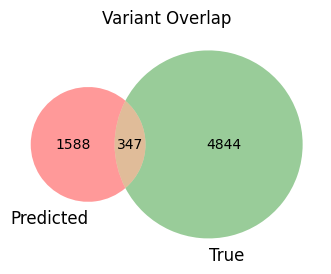

------------------------
k=41
Sample HG00377
Number of variants_predicted: 1775
Number of variants_true: 5191
Number of variants_all: 178549
Number of TP: 328
Number of FP: 1447
Number of FN: 4863
Number of TN: 175653
Accuracy: 0.965
Sensitivity: 0.063
Specificity: 0.992


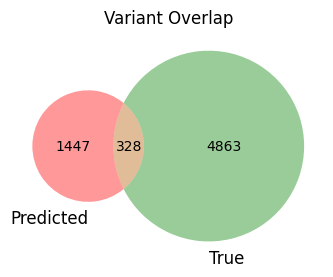

------------------------
k=51
Sample HG00377
Number of variants_predicted: 29
Number of variants_true: 5191
Number of variants_all: 1656
Number of TP: 2
Number of FP: 27
Number of FN: 5189
Number of TN: 1572
Accuracy: 0.232
Sensitivity: 0.000
Specificity: 0.983


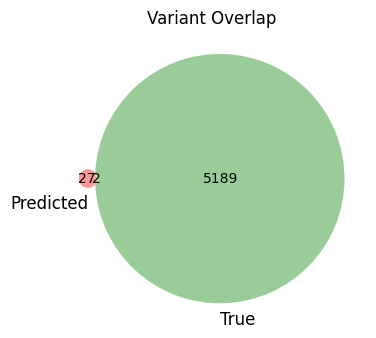

------------------------


In [10]:
# TODO: I currently ran vk ref with merge_identical=False, but in the future, I would like to do this with True, resolve merged headers with reference genome alignment, and then filter out whichever merged headers remain
def plot_variant_overlap(adata_vcrs_path, adata_genotype_path, sample_index=1, min_counts=None, out_path=None):
    if isinstance(adata_vcrs_path, str):
        adata_vcrs = ad.read_h5ad(adata_vcrs_path)
    elif isinstance(adata_vcrs_path, ad.AnnData):
        adata_vcrs = adata_vcrs_path.copy()
    else:
        raise ValueError("adata_vcrs_path must be a string or an AnnData object.")
    if "vcrs_header" in adata_vcrs.var.columns:
        adata_vcrs.var["variant_header"] = adata_vcrs.var["vcrs_header"].copy()
    if "variant_header" not in adata_vcrs.var.columns:
        adata_vcrs.var["variant_header"] = adata_vcrs.var.index.copy()

    if isinstance(adata_genotype_path, str):
        adata_genotype = ad.read_h5ad(adata_genotype_path)
    elif isinstance(adata_genotype_path, ad.AnnData):
        adata_genotype = adata_genotype_path.copy()
    else:
        raise ValueError("adata_genotype_path must be a string or an AnnData object.")
    
    # Select only the sample_index'th sample
    sample_title = adata_vcrs.obs.iloc[sample_index]['sample_title']
    print(f"Sample {sample_title}")
    adata_genotype.obs.index = adata_genotype.obs.index.astype(str)
    adata_genotype.obs['sample_title'] = adata_genotype.obs.index.copy().str.slice(2)
    if sample_title not in set(adata_genotype.obs['sample_title']):
        raise ValueError(f"Sample title {sample_title} not found in adata_genotype.")
    
    adata_vcrs = adata_vcrs[sample_index, :]
    adata_genotype = adata_genotype[adata_genotype.obs['sample_title'] == sample_title].copy()

    if min_counts is not None:
        adata_vcrs.X = adata_vcrs.X.multiply(adata_vcrs.X >= min_counts)
    
    variants_all = set(adata_vcrs.var["variant_header"])

    # Filter adata_vcrs: keep only columns where the value in the first row is not 0
    nonzero_vcrs_cols = adata_vcrs.X[0] > 0
    adata_vcrs = adata_vcrs[:, nonzero_vcrs_cols]
    variants_predicted = set(adata_vcrs.var["variant_header"])

    # Filter adata_genotype: keep only columns where the value in the first row is not 0
    nonzero_genotype_cols = adata_genotype.X[0] > 0
    adata_genotype = adata_genotype[:, nonzero_genotype_cols]
    variants_true = set(adata_genotype.var["variant_header"])

    # ensure no version numbers on Ensembl transcript IDs
    variants_predicted = {re.sub(r'(ENST\d+)\.\d+', r'\1', v) for v in variants_predicted}
    variants_true = {re.sub(r'(ENST\d+)\.\d+', r'\1', v) for v in variants_true}

    # print(f"First 100 variants_true: {sorted(list(variants_true))[:100]}")
    # print(f"First 100 variants_predicted: {sorted(list(variants_predicted))[:100]}")

    TP = len(variants_predicted & variants_true)
    FP = len(variants_predicted - variants_true)
    FN = len(variants_true - variants_predicted)
    TN = len(variants_all - variants_true - variants_predicted)

    global dict_of_fp_and_fn
    dict_of_fp_and_fn[f"w{w}_k{k}"] = {}
    dict_of_fp_and_fn[f"w{w}_k{k}"]["FP"] = variants_predicted - variants_true
    dict_of_fp_and_fn[f"w{w}_k{k}"]["FN"] = variants_true - variants_predicted
    # print(f"First 100 FP: {sorted(list(variants_predicted - variants_true))[:100]}")
    # print(f"First 100 FN: {sorted(list(variants_true - variants_predicted))[:100]}")

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) else 0
    specificity = TN / (TN + FP) if (TN + FP) else 0

    print(f"Number of variants_predicted: {len(variants_predicted)}")
    print(f"Number of variants_true: {len(variants_true)}")
    print(f"Number of variants_all: {len(variants_all)}")
    print(f"Number of TP: {TP}")
    print(f"Number of FP: {FP}")
    print(f"Number of FN: {FN}")
    print(f"Number of TN: {TN}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Sensitivity: {sensitivity:.3f}")
    print(f"Specificity: {specificity:.3f}")

    plt.figure(figsize=(4, 4))
    venn2([variants_predicted, variants_true], set_labels=('Predicted', 'True'))
    plt.title("Variant Overlap")
    if out_path:
        plt.savefig(out_path, dpi=300)
    plt.show()

dict_of_fp_and_fn = {}
for w_and_k_dict in w_and_k_list_of_dicts:
    w, k = w_and_k_dict["w"], w_and_k_dict["k"]
    adata_combined_path_vcrs = os.path.join(sequencing_data_out_base, f"adata_vcrs_combined_w{w}_k{k}.h5ad")
    if not os.path.isfile(adata_combined_path_vcrs):
        vk.utils.download_box_url(box_links_dict[f"geuvadis_adata_vcrs_w{w}_k{k}"], output_file_name=adata_combined_path_vcrs)
    
    print(f"k={k}")
    venn_out_path = os.path.join(out_dir, f"variant_overlap_sample_{sample_index}_w{w}_k{k}.png")
    plot_variant_overlap(adata_combined_path_vcrs, adata_genotype, out_path=venn_out_path, sample_index=sample_index, min_counts=min_counts)
    print("------------------------")

    # break  #!!! erase

## Based on this, I will choose k=41

In [11]:
w, k = 37, 41
adata_combined_path_vcrs_final = os.path.join(sequencing_data_out_base, f"adata_vcrs_combined_w{w}_k{k}.h5ad")
if not os.path.isfile(adata_combined_path_vcrs_final):
    vk.utils.download_box_url(box_links_dict[f"geuvadis_adata_vcrs_w{w}_k{k}"], output_file_name=adata_combined_path_vcrs_final)

adata_vcrs = ad.read_h5ad(adata_combined_path_vcrs_final)
if min_counts is not None:
    adata_vcrs.X = adata_vcrs.X.multiply(adata_vcrs.X >= min_counts)

if "vcrs_count" not in adata_vcrs.var.columns:
    adata_vcrs.var["vcrs_count"] = adata_vcrs.X.sum(axis=0).A1 if hasattr(adata_vcrs.X, "A1") else np.asarray(adata_vcrs.X.sum(axis=0)).flatten()

adata_vcrs.var = adata_vcrs.var.merge(variants_transcriptome_df[['variant_header', 'variant_header_cdna', 'transcript_ID']], how="left", left_index=True, right_on="variant_header_cdna").reset_index(drop=True)
adata_vcrs.var.rename(columns={"variant_header": "variant_header_cds", "variant_header_cdna": "variant_header", "vcrs_count": "variant_count"}, inplace=True)

t2g_dict = vk.utils.make_t2g_dict(reference_genome_t2g)
t2g_dict = {key.split(".")[0]: val.split(".")[0] for key, val in t2g_dict.items()}  # strip off the version number
adata_vcrs.var["gene"] = adata_vcrs.var["transcript_ID"].map(t2g_dict)

/home/jmrich/Desktop/varseek/varseek/utils/varseek_clean_utils.py:2229: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  t2g_df = pd.read_csv(t2g_file, sep="\t", header=None)


In [12]:
#!!!! TEMP - DELETE
adata_reference.obs['experiment_alias_underscores_only'] = (
    adata_reference.obs['experiment_alias_underscores_only']
    .str.replace(r'[.:]', '_', regex=True)
)

In [13]:
# print(adata_vcrs.var.sort_values('vcrs_count', ascending=False))
sample_title, experiment_alias_underscores_only = adata_vcrs.obs.iloc[sample_index]['sample_title'], adata_vcrs.obs.iloc[sample_index]['experiment_alias_underscores_only']
adata_vcrs_single_sample = adata_vcrs[adata_vcrs.obs['experiment_alias_underscores_only'].isin({experiment_alias_underscores_only})].copy()
adata_vcrs_single_sample.var["vcrs_count"] = adata_vcrs_single_sample.X.sum(axis=0).A1 if hasattr(adata_vcrs_single_sample.X, "A1") else np.asarray(adata_vcrs_single_sample.X.sum(axis=0)).flatten()

adata_reference_single_sample = adata_reference[adata_reference.obs['experiment_alias_underscores_only'].isin({experiment_alias_underscores_only})].copy()
adata_reference_single_sample.var['gene_count'] = adata_reference_single_sample.X.toarray().flatten()

adata_genotype_single_sample = adata_genotype[adata_genotype.obs['sample_title'].isin({sample_title})].copy()
adata_genotype_single_sample.var['genotype'] = adata_genotype_single_sample.X.toarray().flatten()

adata_vcrs_single_sample.var = adata_vcrs_single_sample.var.merge(adata_reference_single_sample.var[["gene", "gene_count"]], how="left", on="gene")
adata_vcrs_single_sample.var = adata_vcrs_single_sample.var.merge(adata_genotype_single_sample.var[["variant_header", "genotype"]], how="left", on="variant_header")
adata_vcrs_single_sample.var.index = adata_vcrs_single_sample.var.index.astype(str)

# Save to file
fns_txt_path = os.path.join(out_dir, "fns.txt")
if not os.path.isfile(fns_txt_path):
    with open(fns_txt_path, "w") as f:
        for item in dict_of_fp_and_fn[f"w{w}_k{k}"]["FN"]:
            f.write(f"{item}\n")

fp_df = (
    adata_vcrs_single_sample.var.loc[
    adata_vcrs_single_sample.var['variant_header'].isin(dict_of_fp_and_fn[f"w{w}_k{k}"]["FP"])]
    .sort_values('vcrs_count', ascending=False)
)

fp_df_output_path = os.path.join(out_dir, "fp_df.parquet")
if not os.path.isfile(fns_txt_path):
    fp_df.to_parquet(fp_df_output_path)
fp_df.head()

,variant_count,variant_header_cds,variant_header,transcript_ID,gene,vcrs_count,gene_count,genotype
175115,1848.0,ENST00000390312.2:c.177G>A,ENST00000390312:c.218G>A,ENST00000390312,ENSG00000211666,1848.0,5781.0,0.0
112040,1493.0,ENST00000336023.5:c.519A>G,ENST00000336023:c.614A>G,ENST00000336023,ENSG00000123416,1493.0,11255.0,0.0
58633,1464.0,ENST00000579721.1:c.870G>C,ENST00000579721:c.870G>C,ENST00000579721,NaN,1464.0,NaN,0.0
23451,1382.0,ENST00000496168.1:c.201G>A,ENST00000496168:c.382G>A,ENST00000496168,ENSG00000243466,1382.0,3425.0,0.0
58578,1346.0,ENST00000579721.1:c.41C>T,ENST00000579721:c.41C>T,ENST00000579721,NaN,1346.0,NaN,0.0


In [14]:
adata_genotype_single_sample.var.head()

,has_id,ID,variant_header_cds,variant_header,genotype
0,True,rs200036735,ENST00000327044.6:c.106C>T,ENST00000327044:c.156C>T,0.0
1,True,rs201791495,ENST00000327044.6:c.57C>T,ENST00000327044:c.107C>T,0.0
2,True,rs192245893,ENST00000338591.3:c.90A>C,ENST00000338591:c.197A>C,0.0
3,True,rs200516692,ENST00000338591.3:c.163G>A,ENST00000338591:c.270G>A,0.0
4,True,rs199679371,ENST00000338591.3:c.189G>A,ENST00000338591:c.296G>A,0.0


In [ ]:
genotype_value_to_string_mapping = {0: "homozygous_ref", 1: "heterozygous", 2: "homozygous_alt"}
for genotype_value, genotype_string in genotype_value_to_string_mapping.items():
    number_of_variants_with_this_genotype = len(adata_genotype_single_sample.var.loc[adata_genotype_single_sample.var['genotype'] == genotype_value])
    print(f"Number of variants in sample {sample_title} with genotype {genotype_string}: {number_of_variants_with_this_genotype}")

Number of variants in sample HG00377 with genotype homozygous_ref: 198681
Number of variants in sample HG00377 with genotype heterozygous: 0
Number of variants in sample HG00377 with genotype homozygous_alt: 5191


In [16]:
adata_vcrs_single_sample = adata_vcrs_single_sample[:, (adata_vcrs_single_sample.var['genotype'] > 0) & (adata_vcrs_single_sample.var['vcrs_count'] > 0) & (~adata_vcrs_single_sample.var['gene'].isna())].copy()
adata_vcrs_single_sample

AnnData object with n_obs × n_vars = 1 × 294
    obs: 'experiment_alias_underscores_only', 'experiment_accession', 'library_strategy', 'sample_title', 'Sex', 'Biosample ID', 'Population name', 'Superpopulation name'
    var: 'variant_count', 'variant_header_cds', 'variant_header', 'transcript_ID', 'gene', 'vcrs_count', 'gene_count', 'genotype'

In [17]:
adata_vcrs_single_sample.var.head()

,variant_count,variant_header_cds,variant_header,transcript_ID,gene,vcrs_count,gene_count,genotype
441,6.0,ENST00000355826.5:c.214T>C,ENST00000355826:c.253T>C,ENST00000355826,ENSG00000197530,6.0,169.0,2.0
590,41.0,ENST00000355716.4:c.50A>G,ENST00000355716:c.349A>G,ENST00000355716,ENSG00000157873,41.0,782.0,2.0
3189,4.0,ENST00000374651.4:c.1448A>G,ENST00000374651:c.1543A>G,ENST00000374651,ENSG00000184677,4.0,383.0,2.0
3511,4.0,ENST00000374338.4:c.654A>G,ENST00000374338:c.773A>G,ENST00000374338,ENSG00000157978,4.0,475.0,2.0
3618,45.0,ENST00000270812.5:c.177T>C,ENST00000270812:c.219T>C,ENST00000270812,ENSG00000142684,45.0,236.0,2.0


## Scatterplot time

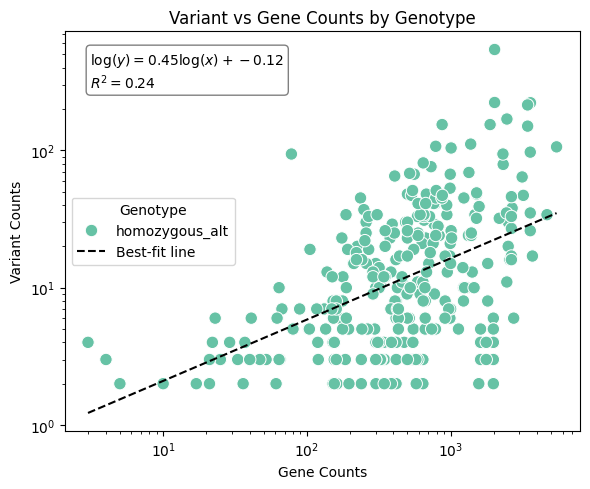

In [18]:
from scipy.stats import linregress

scatterplot_df = adata_vcrs_single_sample.var[["variant_count", "gene_count", "genotype"]].copy()
scatterplot_df["genotype"] = scatterplot_df["genotype"].astype("category")
scatterplot_df["genotype"] = scatterplot_df["genotype"].cat.rename_categories({0: "homozygous_ref", 1: "heterozygous", 2: "homozygous_alt"})

scatterplot_df = scatterplot_df[(scatterplot_df["variant_count"] > 0) & (scatterplot_df["gene_count"] > 0)].copy()

# Log-transform for regression
x_log = np.log10(scatterplot_df["gene_count"])
y_log = np.log10(scatterplot_df["variant_count"])

# Fit line in log-log space
slope, intercept, r_value, p_value, std_err = linregress(x_log, y_log)

# Predicted line (in log space)
x_vals = np.linspace(x_log.min(), x_log.max(), 100)
y_vals = slope * x_vals + intercept

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=scatterplot_df,
    y="variant_count",
    x="gene_count",
    hue="genotype",
    palette="Set2",
    s=80  # adjust marker size
)

# Plot best-fit line
plt.plot(10**x_vals, 10**y_vals, color="black", linestyle="--", label="Best-fit line")

# Annotate equation and R²
eq_text = f"$\log(y) = {slope:.2f} \log(x) + {intercept:.2f}$\n$R^2 = {r_value**2:.2f}$"
plt.text(0.05, 0.95, eq_text, transform=plt.gca().transAxes,
         verticalalignment='top', fontsize=10, bbox=dict(boxstyle="round", fc="white", ec="gray"))

plt.title("Variant vs Gene Counts by Genotype")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Variant Counts")
plt.xlabel("Gene Counts")
plt.legend(title="Genotype")
plt.tight_layout()
out_file = os.path.join(out_dir, f"variant_vs_gene_counts_scatterplot_sample_{sample_index}_w{w}_k{k}.png")
plt.savefig(out_file, dpi=300)
plt.show()